In [68]:
from pathlib import Path
import pandas as pd 
import numpy as np 
import holoviews as hv
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


In [69]:
INJECTION_DATA_DIR = Path('data/inj/')
PORE_PRESSURE_DATA_DIR = Path('data/pp/')


In [70]:
def parse_year_month(year_month):
    year = int(np.floor(year_month))
    month_dec = np.round(year_month - year, 2)
    month_int = int(np.round(month_dec * 12))
    return [year, month_int]

In [71]:

def parse_pp_data(filename):
    """
    Returns longitude, lattitude, pore pressure dataframe for a given pore pressure data file
    """    
#     print(filename)
    df_pp = pd.read_csv(filename, sep=' ', header=None, names=['year_month', 'pp'])
    df_pp = df_pp.groupby('year_month').agg(sum).reset_index()
    # convert year_month from decimal format to year, month integer format
    x = df_pp.year_month.apply(parse_year_month)
    df_temp = pd.DataFrame(x.to_list(), columns=['year', 'month'])
    df_pp = pd.concat([df_temp, df_pp], axis=1)

    fname_split = filename.stem.split('_')
    return fname_split[1], fname_split[2], df_pp


In [72]:
# prepare pore pressure data
pore_pressure_data_files = list(PORE_PRESSURE_DATA_DIR.glob('*.txt'))
pp_lat_lon_data = {}
for filename in pore_pressure_data_files:
    lat, lon, df_pp = parse_pp_data(filename)
    pp_lat_lon_data[lat, lon] = df_pp


In [73]:
def parse_injection_data(filename):
    """
    Returns longitude, lattitude, injection volume dataframe for a given injection volume data file
    """
#     print(filename)
    df_inj = pd.read_csv(filename, sep=' ', header=None, names=['year_month', 'injection_volume'])
    # convert year_month from decimal format to year, month integer format
    x = df_inj.year_month.apply(parse_year_month)
    df_temp = pd.DataFrame(x.to_list(), columns=['year', 'month'])
    df_inj = pd.concat([df_temp, df_inj], axis=1)

    fname_split = filename.stem.split('_')
    return fname_split[1], fname_split[2], df_inj


In [74]:
# prepare injection data
injection_data_files = list(INJECTION_DATA_DIR.glob('*.txt'))
injection_lat_lon_data = {}
for filename in injection_data_files:
    lat, lon, df_inj = parse_injection_data(filename)
    injection_lat_lon_data[lat, lon] = df_inj



## Plotting

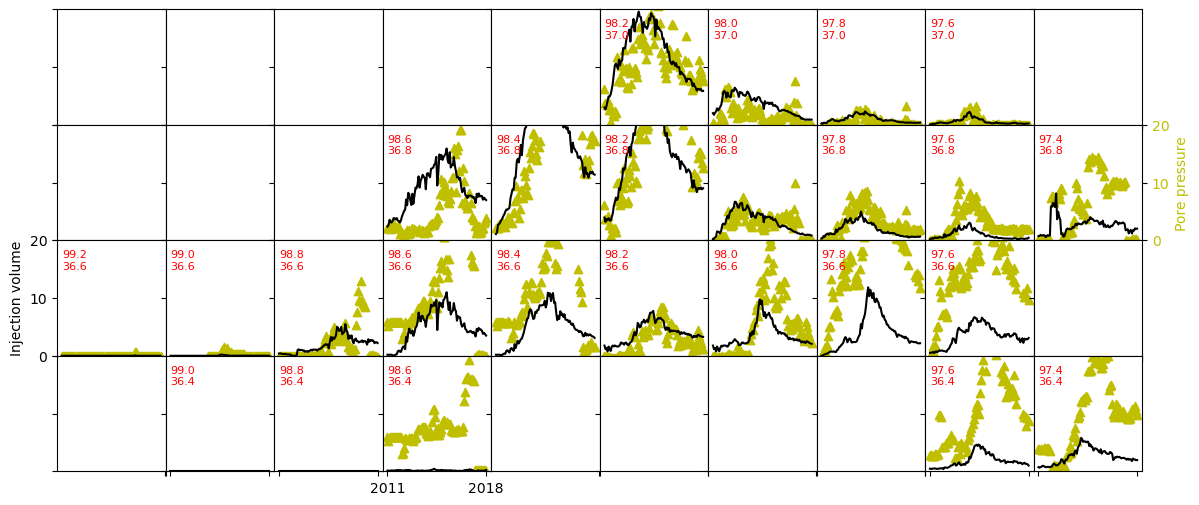

In [75]:
fig, axes = plt.subplots(4,10,sharex=False,sharey=False,figsize=(14,6))
axes = axes.ravel()

max_inj_vol = 20

ax_idx = 0
init=False
for lon in np.arange(37.0, 36.2, -0.2):
    for lat in np.arange(99.2, 97.2, -0.2):
        ax = axes[ax_idx]
        lat_s = "%3.1f"%(lat)
        lon_s = "%3.1f"%(lon)
        if (lat_s,lon_s) in injection_lat_lon_data.keys():
#             print(lat_s, lon_s)
            df_inj = injection_lat_lon_data[(lat_s,lon_s)]
            # plot injection volume
            ax.plot(df_inj.year_month,df_inj.injection_volume, color='k')
            # plot pore pressure
            df_pp = pp_lat_lon_data[(lat_s,lon_s)]
            if not df_pp.empty:
                ax.scatter(df_pp.year_month,df_pp.pp, marker="^", color='y')
            # co-ordinate text overlay
            ax.text(2011.00, max_inj_vol - 5, '%s\n%s'%(lat_s, lon_s), fontsize=8, color='r')

        # set injection volume limit
        ax.set_ylim([0, max_inj_vol])
        yticks = np.linspace(0, max_inj_vol, 3).astype('int')
        ax.set_yticks(yticks)
        ax.set_xticks([2011.00, 2018.92])
        
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        # injection volume y axis label
        if lat_s == "99.2" and lon_s == "36.6":
            ax.set_yticklabels(yticks, color='k')
            ax.set_ylabel("Injection volume", color='k')
        # injection volume y axis label
        if lat_s == "97.4" and lon_s == "36.8":
            ax.yaxis.tick_right()
            ax.set_yticklabels(yticks, color='y', )
            ax.set_ylabel("Pore pressure", color='y')
            ax.yaxis.set_label_position("right")

        if lat_s == "98.6" and lon_s == "36.4":
            ax.set_xticklabels([2011, 2018])
        
        ax_idx += 1

# fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()